In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from qiskit.aqua.components.optimizers import ADAM
import warnings
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from qulacs import QuantumCircuit
from qulacs import QuantumState
from qulacs import Observable
from qulacs import ParametricQuantumCircuit
from qulacs.gate import X, Z
from qulacs.gate import DenseMatrix
from functools import reduce
from scipy.optimize import minimize

In [ ]:
# https://dojo.qulacs.org/ja/latest/notebooks/5.2_Quantum_Circuit_Learning.html
# https://github.com/qulacs/quantum-native-dojo/blob/master/notebooks/qcl_classification.py
# の2つを参考にした

In [ ]:
# getoutputとU_inは入力次元に応じて書き換えるしかない

In [ ]:
# global変数の宣言

In [92]:
nqubit = 6
depth = 6
num_class = 2

In [93]:
# 結果を入れるhashmap
d = {}

In [94]:
obs = [Observable(nqubit) for _ in range(num_class)]
for i in range(num_class):
    obs[i].add_operator(1.,f"Z {i}")

In [95]:
# ここで入力データを作成

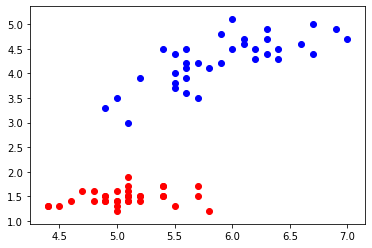

In [96]:
# iris data
iris = datasets.load_iris()
x,y = iris.data[:100,[0,2]],iris.target[:100]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
for i in range(len(x_train)):
    if y_train[i] == 0:
        plt.scatter(x_train[i][0],x_train[i][1],color = "red")
    elif y_train[i] == 1:
        plt.scatter(x_train[i][0],x_train[i][1],color = "blue")

In [97]:
#これは正規化が必要な時に行う、一応やったほうが安全？
mn = MinMaxScaler(feature_range=(-1,1),copy = True)
x_train = mn.fit_transform(x_train)
x_test = mn.fit_transform(x_test)

x_train[x_train < -1] = -1
x_train[x_train > 1] = 1
x_test[x_test < -1] = -1
x_test[x_test > 1] = 1

In [98]:
numTrainData = len(x_train)

In [99]:
numdim = len(x_train[0])

In [100]:
qc_map = {}  
# x_train内のindex:対応するQuantumCircuitオブジェクト(ただしU(x)のみ保存している点がqiskitと違う)
#これはdepthやnqubitを変えるたびに初期化する
# テストデータに関しては1回ずつしか呼び出されないから特に保存しない

In [101]:
# ここでハミルトニアンを含むゲートを作る
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

## fullsizeのgateをつくる関数.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...] を受け取り,
    関係ないqubitにIdentityを挿入して
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    という(2**nqubit, 2**nqubit)行列をつくる.
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## 1-qubit gateを並べてnp.kronでreduceする
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## 何もないsiteはidentity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

#### ランダム磁場・ランダム結合イジングハミルトニアンをつくって時間発展演算子をつくる
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## -1~1の乱数
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## 対角化して時間発展演算子をつくる. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

In [102]:
def U_in(x):    #入力xをエンコードするゲートが付いた回路（QuantumCircuit）を返す
    # 入力が1次元か多次元化に応じて少しコードを変える
    U = QuantumCircuit(nqubit)
    for i in range(nqubit):
        angle_y = np.arcsin(x[i%numdim])
        angle_z = np.arccos(x[i%numdim]**2)
        U.add_RY_gate(i,angle_y)
        U.add_RZ_gate(i,angle_z)
    
    return U
# 入力次元が1の場合でもリストで渡す必要がある

In [103]:
def createInitialAnsatz(depth):  # ansatzに相当する部分のオブジェクトを作る、これはグローバル変数として1つのみ作る
    U = ParametricQuantumCircuit(nqubit)
    for d in range(depth):
        U.add_gate(time_evol_gate)  # ハミルトニアンを含むゲートの追加
        for i in range(nqubit):
            U.add_parametric_RX_gate(i, 2*np.pi*np.random.rand())
            U.add_parametric_RZ_gate(i, 2*np.pi*np.random.rand())
            U.add_parametric_RX_gate(i, 2*np.pi*np.random.rand())
        
    return U

In [104]:
def getoutput(x,init_par):   #入力x(リスト)、出力yの予測値
    # 入力が1次元なら(x,), 多次元ならtuple(x)とする
    tupled_x = tuple(x)
    if tupled_x in qc_map:
        U_In = qc_map[tupled_x]
    else:
        U_In = U_in(x)
        qc_map[tupled_x] = U_In
    for i in range(len(init_par)):  # まずここで回路内のパラメータを更新
        U_out.set_parameter(i, init_par[i])
        
    state = QuantumState(nqubit)
    state.set_zero_state()
    
    U_In.update_quantum_state(state)
    
    U_out.update_quantum_state(state)
    res = [o.get_expectation_value(state) for o in obs]  # [<Z0>,<Z1>...]のリスト
    return np.array(res)

In [105]:
def softmax(x):  #xはndarrayじゃなきゃだめ
    max_x = np.max(x)
    exp_x = np.exp(x-max_x)
    return exp_x / np.sum(exp_x)

In [106]:
def cost_func_helper(x,y,par):
    outputs = getoutput(x,par)  # 期待値のリスト
    noutputs = softmax(outputs) # それにソフトマックス関数をかけた後のリスト
    return -np.log(noutputs[y])

In [107]:
def cost_func(par):
    res = 0.
    for x,y in zip(x_train,y_train):
        res += cost_func_helper(x,y,par)
    return res

In [108]:
def gene_error(par):
    # 現在のパラメータ値がparの時のテストデータに対するコスト関数の値を返す
    res = 0.
    for x,y in zip(x_test,y_test):
        res += cost_func_helper(x,y,par)
    return res

In [109]:
def deriv_func(par):
    res = []
    n = len(par)
    data = it.next()  # このデータだけを使って勾配を求める
    numdata = len(data)  # バッチサイズと同じ
    
    for i in range(n):
        temp = 0.
        for j in range(numdata):
            x,y = data[j][0],data[j][1]
            grads = compute_gradient1(x,par,i)
            temp += (sum(grads) - grads[y])
        res.append(temp)
    res = np.array(res)
    return res

In [110]:
def compute_gradient1(x,par,i):
    par[i] += np.pi/2.
    b_plus = getoutput(x,par)
    par[i] -= np.pi/2.
    par[i] -= np.pi/2.
    b_minus = getoutput(x,par)
    par[i] += np.pi/2.
    return (b_plus - b_minus)/2.

In [111]:
class Iterator:
    def __init__(self,x,y,batch_size):
        self.x = x_train   # 訓練データの入力、ndarray
        self.y = y_train   # 訓練データの出力、ddarray
        self.batch_size = batch_size  # バッチサイズ(1以上)
        self.index = 0  # データ内のどのindexを見ているかを保持する
        self.indices = list(range(len(x_train)))  # この配列を適宜シャッフルする
        
    def next(self):   # バッチサイズ分のデータをリストに入れて変えす、途中でデータを見終わったらシャッフルする
        res = []
        for _ in range(self.batch_size):
            nx = self.x[self.indices[self.index]]
            ny = self.y[self.indices[self.index]]
            res.append((nx,ny))
            self.index += 1
            if self.index == len(self.x):
                self.index = 0
                np.random.shuffle(self.indices)
        res = np.array(res)
        return res

In [112]:
# ここから学習

In [113]:
U_out = createInitialAnsatz(depth)  # これもグローバルに1つのみ
parameter_count = U_out.get_parameter_count()
init_par = [U_out.get_parameter(i) for i in range(parameter_count)]  # これが初期パラメータ値を持ったリスト

In [114]:
it = Iterator(x = x_train,y = y_train,batch_size = 30)

In [115]:
start = time.time()

result = minimize(fun = cost_func,x0 = init_par,method = "cg",jac = deriv_func)  # (最適パラメータ、その時のコスト関数値、イテレーション数)を返す
par = result.x
d[depth] = d.get(depth,[]) + [(cost_func(par),gene_error(par))]  # (最適パラメータ、その時のコスト関数値、その時のテストデータに対するコスト関数値)を保存

process_time = time.time() - start

print(d[depth])
print(process_time)

[(34.91990410800374, 15.719392647903002)]
398.59374594688416


In [ ]:
# ここから結果の解釈(結果の図示や情報量の計算を行う)

In [41]:
def predict(x,par):   #入力x(2次元のみ)、最適化したパラメータ、出力yの予測クラスラベル
    tupled_x = tuple(x)
    if tupled_x in qc_map:
        U_In = qc_map[tupled_x]
    else:
        U_In = U_in(x)
        qc_map[tupled_x] = U_In
    for i in range(len(init_par)):  # まずここで回路内のパラメータを更新
        U_out.set_parameter(i, par[i])
        
    state = QuantumState(nqubit)
    state.set_zero_state()
    
    U_In.update_quantum_state(state)
    
    U_out.update_quantum_state(state)
    res = [o.get_expectation_value(state) for o in obs]  # [<Z0>,<Z1>...]のリスト
    res = np.array(res)
    res = softmax(res)
    res = list(res)
    return res.index(max(res))   #res[i] = <Z_i>にソフトマックス関数を掛けた値(iは上位i番目のqubitということを表す)

In [42]:
# 2次元の時に結果を図示できる、訓練データ用
def plot_decision_regions(par):  
    x1_min,x1_max = x_train[:,0].min(),x_train[:,0].max()  # ここを[-1,1]の範囲に収めないとnp.arcsin,np.arccosがnanとなりエラーになる
    x2_min,x2_max = x_train[:,1].min(),x_train[:,1].max()
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,0.08),
                         np.arange(x2_min,x2_max,0.08))
    points = np.array([xx1.ravel(),xx2.ravel()]).T
    z = []
    for i,j in points:
        z.append(predict([i,j],par))
    z = np.array(z)
    z = z.reshape(xx1.shape)
    
    plt.contourf(xx1,xx2,z,alpha = 0.3)
    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    
    for i in range(len(x_train)):
        if y_train[i]== 0:
            plt.scatter(x_train[i][0],x_train[i][1],color = "red")
        else:
            plt.scatter(x_train[i][0],x_train[i][1],color = "blue") 

In [43]:
# 2次元の時に結果を図示できる、テストデータ用
def plot_decision_regions2(par):
    x1_min,x1_max = x_train[:,0].min(),x_train[:,0].max()
    x2_min,x2_max = x_train[:,1].min(),x_train[:,1].max()
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,0.08),
                         np.arange(x2_min,x2_max,0.08))
    points = np.array([xx1.ravel(),xx2.ravel()]).T
    z = []
    for i,j in points:
        z.append(predict([i,j],par))
    z = np.array(z)
    z = z.reshape(xx1.shape)
    
    plt.contourf(xx1,xx2,z,alpha = 0.3)
    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    
    for i in range(len(x_test)):
        if y_test[i]== 0:
            plt.scatter(x_test[i][0],x_test[i][1],color = "red")
        else:
            plt.scatter(x_test[i][0],x_test[i][1],color = "blue") 

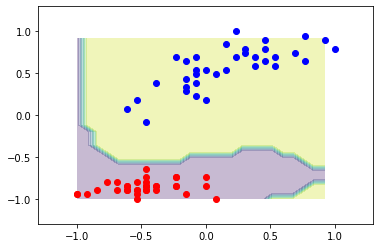

In [116]:
plot_decision_regions(par)